# Preamble

In [1]:
%matplotlib inline

import matplotlib

import matplotlib.pyplot as plt

import numpy as np
import pickle
from scipy.interpolate import interp1d
from scipy.integrate import nquad
from scipy.special import spherical_jn as sjn
import time
from scipy import integrate 

from tqdm import tqdm_notebook as tqdm

# Data from Yacine + Interpolation

In [2]:
corrs=np.loadtxt(open('./correlations.dat'), delimiter="\t")

cparint=interp1d(corrs[:,0],corrs[:,1],kind=9)
cperpint=interp1d(corrs[:,0],corrs[:,2],kind=9)

# Get Raw Data

In [3]:
# Vlis=np.loadtxt(open('../Vrel_scan/extended_redshift_data_fixed_He_bug/Vlis.csv'), delimiter=",")
# Qlis=np.loadtxt(open('../Vrel_scan/extended_redshift_data_fixed_He_bug/Qlis.csv'), delimiter=",")

dir_str = '/tigress/hongwanl/millicharged_DM_with_bath/Vrel_scan_fixed_He_bug/for_Anastasia'

Vlis=np.loadtxt(open(dir_str+'/Vlis.csv'), delimiter=",")
Qlis=np.loadtxt(open(dir_str+'/Qlis.csv'), delimiter=",")
zlis=np.loadtxt(open(dir_str+'/zlis.csv'), delimiter=",")


Vlis *= 29 # To convert to km/s
# Choose the mass to read in. 
# Tbarr=np.loadtxt(open('../Vrel_scan/extended_redshift_data_fixed_He_bug/mc100MeV_mm3_GeV_z_17.csv'), delimiter=",")


z_str = ["{0:.0f}".format(z) for z in zlis]

Tbarr_lis = []

for z in z_str:
    
    Tbarr_lis.append(np.loadtxt(open(dir_str+'/mc100MeV_mm100_MeV_z_'+z+'.csv'), delimiter=','))
    
Tbarr_lis = np.array(Tbarr_lis)

T_gam_0 = 2.72548
T_gam_ary = T_gam_0*(1. + zlis)

# Convert to K
Tbarr_lis /= 8.617333262e-5


# see 1109.6012 Eq. 7 for the definition. It is everything besides (TS - TR)/TS (assuming no peculiar velocity)
prefac = 27. * 0.02237/0.023 * (0.15/0.143 * (1. + zlis)/10.)**0.5

# With the approximation that tau is small, should be (T_s - T_R)/(1+z)*tau (see 1109.6012)
T21lis_small_tau = prefac[:, None, None]*(1. - T_gam_ary[:, None, None] / Tbarr_lis)

# The actual value of tau, from the expression above. T21llis_small_tau is in mK. 
tau = T21lis_small_tau * (1. + zlis[:, None, None]) / ((Tbarr_lis - T_gam_ary[:, None, None]) * 1e3)

T21lis = ((Tbarr_lis - T_gam_ary[:, None, None]) * 1e3) / (1. + zlis[:, None, None]) * (1. - np.exp(-tau))

T21_int = interp1d(Vlis, T21lis)



# def get_T21_int(z_ind, Q_ind):
    
#     z = 17
#     T_gam_0 = 2.72548
#     T_gam_z_17 = T_gam_0*(1. + z)

#     Tblis=Tbarr_lis[z_ind, Q_ind, :]/8.617333262e-5  # To convert to K

#     # see 1109.6012 Eq. 7 for the definition. It is everything besides (TS - TR)/TS (assuming no peculiar velocity)
#     prefac = 27. * 0.02237/0.023 * (0.15/0.143 * (1. + z)/10.)**0.5


#     # With the approximation that tau is small, should be (T_s - T_R)/(1+z)*tau (see 1109.6012)
#     T21lis_small_tau = prefac*(1. - T_gam_z_17/Tblis)

#     # The actual value of tau, from the expression above. T21lis_small_tau is in mK. 
#     tau = T21lis_small_tau * (1. + z) / ((Tblis - T_gam_z_17) * 1e3)

#     # Actual T21 is (T_s - T_R)/(1+z) * (1 - exp(-tau)). Given in mK. 
#     T21lis = ((Tblis - T_gam_z_17) * 1e3) / (1. + z) * (1. - np.exp(-tau))
# #     T21lis = T21lis_small_tau

#     return interp1d(Vlis, T21lis)

# Velocity PDF

In [4]:
sig = 29. / np.sqrt(3)     # 1D variance of relative velocity, in km/s. 

def P_v(v):
    # This is the probability distribution of the relative velocity v. 
    return 4 * np.pi * v**2 / (2.*np.pi)**1.5 / sig**3 * np.exp(-v**2 / 2. / sig**2)



# Two-Point Function

In [5]:
def R(x, y_b):
    
    term_1 = np.outer(cperpint(x)**2, np.ones_like(y_b))
    term_2 = np.outer(cparint(x)**2 - cperpint(x)**2, y_b**2)
    
    return np.sqrt(term_1 + term_2)

def W(v_a, v_b, x):
    
    # Returns a 3-dim array, indexed by v_a, v_b and x. 
    # First velocity v_a and v_b taken to be zero. 
    
    # Adjust this for the y_b integral. 
    y_b = np.linspace(-1,1, 40)
    
    v_squared_sum = np.outer(v_a**2,np.ones_like(v_b)) + np.outer(np.ones_like(v_a), v_b**2)
    one_minus_R_squared = 1. - R(x, y_b)**2
    R_over_one_minus_R_squared = R(x, y_b) / one_minus_R_squared
    
#     term_1 = np.exp(np.einsum('ij,kl->ijkl', -v_squared_sum / 2. / sig**2, 1./one_minus_R_squared ))
#     term_2 = np.sinh(np.einsum('i,j,kl->ijkl', v_a, v_b, R_over_one_minus_R_squared / sig**2))
    
    # Expand sinh as exponentials so as to avoid overflow issues. 
    exp_arg_1 = (
        np.einsum('ij,kl->ijkl', -v_squared_sum / 2. / sig**2, 1./one_minus_R_squared )
        + np.einsum('i,j,kl->ijkl', v_a, v_b, R_over_one_minus_R_squared / sig**2)
    )
    exp_arg_2 = (
        np.einsum('ij,kl->ijkl', -v_squared_sum / 2. / sig**2, 1./one_minus_R_squared )
        + np.einsum('i,j,kl->ijkl', v_a, v_b, -R_over_one_minus_R_squared / sig**2)
    )
    
    term_1 = 0.5 * (np.exp(exp_arg_1) - np.exp(exp_arg_2))

    term_3 = 1. / np.einsum('i,j,kl->ijkl', np.ones_like(v_a), np.ones_like(v_b), R(x, y_b)*np.sqrt(one_minus_R_squared))

    # We absorb 1/(v_a v_b) into the rest of the integrand. 
    
    integrand = 0.5 * term_1 * term_3
    
    return np.trapz(integrand, y_b)


In [6]:
# Loop over charge values


z_inds = np.arange(0, 22, 1)
z_vals = zlis[z_inds]

Q_inds = np.arange(0, 90, 1)
Q_vals = Qlis[Q_inds]

xi_ary_lis = np.zeros((z_inds.size, Q_inds.size, 300))

vel_ary = np.linspace(Vlis[0],Vlis[-1],50);

T21_ary = T21_int(vel_ary)

# Various statistics, dimensions (zlis, Qlis)
mean_T21 = np.trapz(P_v(vel_ary)*T21_ary, vel_ary)
T21_sq_mean = np.trapz(P_v(vel_ary)*T21_ary**2, vel_ary)
T21_p_sq_mean = np.trapz(P_v(vel_ary) * np.gradient(T21_ary, vel_ary, axis=-1)**2, vel_ary)
v_sq_T21_mean = np.trapz(P_v(vel_ary) * vel_ary**2 * T21_ary, vel_ary)

# Differential T_21
delt_T21_ary = T21_ary - mean_T21[:,:,None]

# Array of x values to evaluate the 2-point function at. 
x_ary = 10**np.linspace(-3,3,300)

# Integrand to evaluate, dimensions (zlis, Qlis, vel_ary, vel_ary, x_ary)
xi_integrand_large = np.einsum(
    'lmi,lmj,ijk->lmijk', 
    vel_ary[None,None,:]*delt_T21_ary,      # this includes the 1/v_a from W
    vel_ary[None,None,:]*delt_T21_ary,      # this includes the 1/v_b from W
    W(vel_ary, vel_ary, x_ary[(x_ary >= .5) & (x_ary <= 300.)])
) * 2. / np.pi / sig**4

# Dimensions (zlis, Qlis, x_ary)
xi_ary_num = np.trapz(
    np.trapz(
        xi_integrand_large, vel_ary, axis=-2
    ), vel_ary, axis=-2
) 

# Dimensions (zlis, Qlis, x_ary)
xi_ary_analytic_small = (
    T21_sq_mean[:,:,None] - sig**2 * T21_p_sq_mean[:,:,None] 
    * (1. - (cparint(x_ary) + 2.*cperpint(x_ary))/3.)[None, None, :] - mean_T21[:,:,None]**2
)

# Dimensions (zlis, Qlis, x_ary)
xi_ary_analytic_large = (
    0.5*(cparint(x_ary)**2 + 2*cperpint(x_ary)**2)[None, None, :]
    *(mean_T21[:,:,None] - v_sq_T21_mean[:,:,None] / (3.*sig**2))**2
)

xi_ary_lis[:,:, x_ary < .5]  = xi_ary_analytic_small[:,:,x_ary < .5]
xi_ary_lis[:,:, (x_ary >= .5) & (x_ary <= 300.)] = xi_ary_num
xi_ary_lis[:,:, x_ary > 300.] = xi_ary_analytic_large[:,:,x_ary > 300.]


# for i in tqdm(z_inds):
    
#     for j in tqdm(Q_inds):

#         # Array of velocities in km/s.
#         vel_ary = np.linspace(Vlis[0],Vlis[-1],50);

#         # Get interpolator for T21. 
#         T21_int = get_T21_int(i,j)

#         # Array of T_21 correspondingly.
#         T21_ary = T21_int(vel_ary)

#         # Mean T_21. 
#         mean_T21 = np.trapz(P_v(vel_ary)*T21_ary, vel_ary)
#         T21_sq_mean = np.trapz(P_v(vel_ary)*T21_ary**2, vel_ary)
#         T21_p_sq_mean = np.trapz(P_v(vel_ary) * np.gradient(T21_ary, vel_ary)**2, vel_ary)
#         v_sq_T21_mean = np.trapz(P_v(vel_ary) * vel_ary**2 * T21_ary, vel_ary)

#         # Differential T_21
#         delt_T21_ary = T21_ary - mean_T21

#         # Array of x values to evaluate the 2-point function at. 
#         x_ary = 10**np.linspace(-3,3,300)

#         # Integrand to evaluate
#         xi_integrand_large = np.einsum(
#             'i,j,ijk->ijk', 
#             vel_ary*delt_T21_ary,      # this includes the 1/v_a from W
#             vel_ary*delt_T21_ary,      # this includes the 1/v_b from W
#             W(vel_ary, vel_ary, x_ary[(x_ary >= 1.) & (x_ary <= 300.)])
#         ) * 2. / np.pi / sig**4

#         xi_ary_num = np.trapz(
#             np.trapz(
#                 xi_integrand_large, vel_ary, axis=-2
#             ), vel_ary, axis=-2
#         ) 

#         xi_ary_analytic_small = (
#             T21_sq_mean - sig**2 * T21_p_sq_mean * (1. - (cparint(x_ary) + 2.*cperpint(x_ary))/3.) - mean_T21**2
#         )
        
#         xi_ary_analytic_large = (
#             0.5*(cparint(x_ary)**2 + 2*cperpint(x_ary)**2)*(mean_T21 - v_sq_T21_mean / (3.*sig**2))**2
#         )

#         xi_ary_lis[i, j, x_ary < 1.]  = xi_ary_analytic_small[x_ary < 1.]
#         xi_ary_lis[i, j, (x_ary >= 1.) & (x_ary <= 300.)] = xi_ary_num
#         xi_ary_lis[i, j, x_ary > 300.] = xi_ary_analytic_large[x_ary > 300.]
    
    

In [7]:
import pickle

pickle.dump((z_vals, Q_vals, x_ary, xi_ary_lis), open('xi_mc100MeV_mm100_MeV.dat', 'wb'))

z_vals, Q_vals, x_ary, xi_ary_lis = pickle.load(open('xi_mc100MeV_mm100_MeV.dat', 'rb'))

# Compute the Dimensionless Power Spectrum

In [8]:
# delta_sq_ary = np.zeros((z_inds.size, Q_inds.size))

# k_ary = 10**np.linspace(-2, 0, 1000)

k = 0.1

xi_int = interp1d(x_ary, xi_ary_lis, kind=1)
xi_analytic_large_int = interp1d(x_ary, xi_ary_analytic_large)

x_ary_fine  = np.linspace(0.1, 1000, 20000)
xi_ary_fine = xi_int(x_ary_fine)
xi_analytic_large_fine = xi_analytic_large_int(x_ary_fine)

delta_sq_ary = 2 / np.pi * k**3 * np.trapz(
    xi_ary_fine * x_ary_fine * np.sin(k * x_ary_fine) / k, x_ary_fine
)

delta_sq_analytic_ary = 2 / np.pi * k**3 * np.trapz(
    xi_analytic_large_fine * x_ary_fine * np.sin(k * x_ary_fine) / k, x_ary_fine
)

# Mean T_21. 


# for i in tqdm(z_inds):/
    
#     for j in tqdm(Q_inds):
        
#         vel_ary = np.linspace(Vlis[0],Vlis[-1],50);

#         # Get interpolator for T21. 
#         T21_int = get_T21_int(i,j)

#         # Array of T_21 correspondingly.
#         T21_ary = T21_int(vel_ary)


#         mean_T21 = np.trapz(P_v(vel_ary)*T21_ary, vel_ary)
#         T21_sq_mean = np.trapz(P_v(vel_ary)*T21_ary**2, vel_ary)
#         v_sq_T21_mean = np.trapz(P_v(vel_ary) * vel_ary**2 * T21_ary, vel_ary)
        
#         xi_Vrel_sq = 2*(cparint(x_ary_fine)**2 + 2*cperpint(x_ary_fine)**2) / 9
        
#         xi_ary_analytic_fine[i,j] = 9./4. * (mean_T21 - v_sq_T21_mean / (3. * sig**2))**2 * xi_Vrel_sq
        
# delta_sq_analytic_ary = 2 / np.pi * k**3 * np.trapz(
#     xi_ary_analytic_fine * x_ary_fine * np.sin(k * x_ary_fine) / k, x_ary_fine
# )



Text(0, 0.5, '$\\Delta^2$ [mK$^2$]')

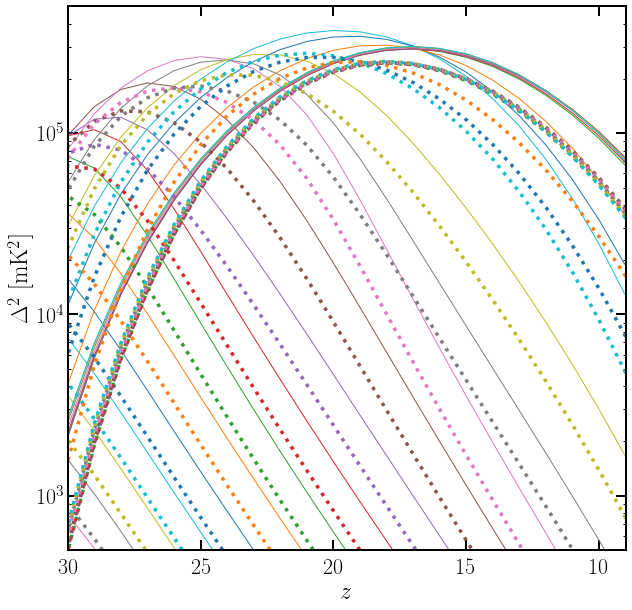

In [9]:
plt.figure(figsize=(10,10))

# plt.loglog()

ax= plt.gca()

ax.set_yscale('log')
ax.set_xlim((30, 9))

# plt.plot(z_vals, delta_sq_ary[:,50])

for delta_sqs in np.transpose(delta_sq_ary[:,0:50:1]):
    
    plt.plot(z_vals, delta_sqs, linewidth=1)
    
ax.set_prop_cycle(None)
    
for delta_sqs in np.transpose(delta_sq_analytic_ary[:,0:50:1]):
    
    plt.plot(z_vals, delta_sqs, linestyle=':')
    
plt.axis([30, 9, 5e2, 5e5])

plt.xlabel(r'$z$')
plt.ylabel(r'$\Delta^2$ [mK$^2$]')

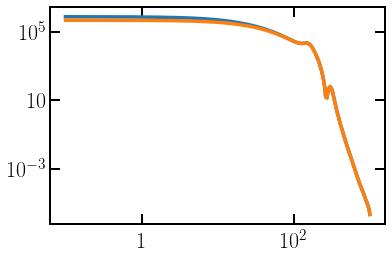

In [10]:
plt.figure()

plt.loglog()

plt.plot(x_ary_fine, xi_ary_fine[8, 40])
# plt.plot(x_ary, xi_ary_lis[8,4])
plt.plot(x_ary_fine, xi_analytic_large_fine[8, 40])

# plt.axis([.1, 3, 1e-18, 1e-4])

In [11]:
xi_ary_fine.shape

(22, 90, 20000)